In [1]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Inputs
CATEGORIES_PATH = '/scratch/WikipediaImagesTaxonomy/commonswiki-20220220-category-network.parquet'

In [20]:
def build_category_graph(categories):
        '''
        Build the category graph, starting from the DataFrame extracted by processing dumps
        '''
        categories = categories.set_index('title')
        # Build DiGraph from adjacency matrix
        G = nx.DiGraph(categories.parents.to_dict())
        nx.set_node_attributes(G, dict(zip(categories.index, categories[['id', 'hiddencat', 'in_en_wiki']].to_dict(orient='records'))))
        depth = {node: len(sps) for node, sps in nx.shortest_path(G, target='CommonsRoot').items()}
        nx.set_node_attributes(G, depth, name='depth')
        return G

In [4]:
categories = pd.read_parquet(CATEGORIES_PATH)
categories.head()

,title,id,parents,hiddencat,childs,in_en_wiki
0,"""A decent story"", by James Gillray",97241532,"[James Gillray, Wine drinking in art, Hannah H...",False,None,False
1,"""Alte Wache"" (Tierpark Berlin)",19337992,"[Buildings in Tierpark Berlin, Eingang Schloss...",False,None,False
2,"""Azərişıq"" ASC",89434922,[Energy in Azerbaijan],False,"[Vugar Ahmadov, Ilham Aliyev attended opening ...",True
3,"""Das Feuer"" (Schlossgarten Bruchsal)",76472979,[Statues of the elements in Schlossgarten Bruc...,False,None,False
4,"""Der Weltkrieg"" (Cigarette card album) - Enemy...",97496426,"[""Der Weltkrieg"" (Cigarette card album)]",False,None,False


In [21]:
G = build_category_graph(categories)

In [22]:
nx.info(G)

/tmp/ipykernel_1594862/1064119803.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'DiGraph with 11197990 nodes and 24643074 edges'

In [23]:
hiddencats = [node for node, hiddencat in nx.get_node_attributes(G, 'hiddencat').items() if hiddencat]
print(f'There are {len(hiddencats)} identified hidden categories, corresponding to the ' +
      f'{len(hiddencats) / G.number_of_nodes() * 100 :.2f}% of all categories')

There are 137447 identified hidden categories, corresponding to the 1.23% of all categories


In [25]:
in_wiki_cats = [node for node, in_wiki in nx.get_node_attributes(G, 'in_en_wiki').items() if in_wiki]
print(f'There are {len(in_wiki_cats)} categories with images appearing in en.wiki, corresponding to the ' +
      f'{len(in_wiki_cats) / G.number_of_nodes() * 100 :.2f}% of all categories')

There are 2921404 categories with images appearing in en.wiki, corresponding to the 26.09% of all categories


In [26]:
depth = nx.get_node_attributes(G, 'depth')

In [27]:
print(f'There are {len(depth)} nodes connected to CommonsRoot, corresponding to the ' +
      f'{len(depth) / G.number_of_nodes() * 100 :.2f}% of all categories')

There are 8522433 nodes connected to CommonsRoot, corresponding to the 76.11% of all categories


In [28]:
sorted(Counter(depth.values()).items(), key=lambda x: x[0])

[(1, 1),
 (2, 7),
 (3, 124),
 (4, 2964),
 (5, 180965),
 (6, 455397),
 (7, 1304298),
 (8, 2133584),
 (9, 2357983),
 (10, 1334780),
 (11, 494834),
 (12, 105615),
 (13, 28322),
 (14, 17101),
 (15, 16148),
 (16, 20381),
 (17, 22943),
 (18, 14505),
 (19, 15301),
 (20, 6743),
 (21, 1485),
 (22, 1335),
 (23, 1842),
 (24, 1586),
 (25, 2497),
 (26, 835),
 (27, 574),
 (28, 258),
 (29, 10),
 (30, 10),
 (31, 5)]

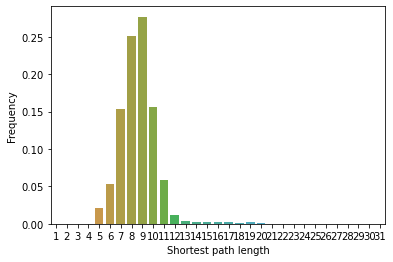

In [29]:
counts = pd.Series(depth).value_counts(sort=False, normalize=True)
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('Shortest path length')
plt.ylabel('Frequency')
plt.show()

In [30]:
not_connected_nodes = set(G.nodes) - set(depth.keys())

In [31]:
# Examples of nodes that cannot reach CommonsRoot
list(not_connected_nodes)[:10]

['',
 'Photographs taken on 1947-04-17',
 'Italy photographs taken on 2021-08-20',
 'Quinquelingual English-German-Hebrew-Hungarian-Polish signs',
 'Italy photographs taken on 2016-03-18',
 'Afghanistan photographs taken on 2007-08-11',
 '2001 in mining in North Rhine-Westphalia',
 'People from Monongalia County, West Virginia',
 '50005 (number)',
 "Saint-Aignan (Loir-et-Cher) in Médiathèque de l'architecture et du patrimoine"]

Almost all those categories in reality are connected, but they have ancestors added via templates (ex. Virginia State Route 7298 or Religious organizations established in 1123). For now, we didn't manage to get the template expansion working, so categories added through templates are not available.

In [32]:
G.out_edges('Virginia State Route 7298')

OutEdgeDataView([])

In [37]:
leaf_it = (x for x in G.nodes() if G.in_degree(x) == 0)
wiki_leaf_it = (x for x in G.nodes() if G.in_degree(x) == 0 and G.nodes[x].get('in_en_wiki', 0))
nleaves = sum(1 for _ in leaf_it)
nleaves_wiki = sum(1 for _ in wiki_leaf_it)

print(f'There are {nleaves} leaf nodes, corresponding to the ' +
      f'{nleaves / G.number_of_nodes() * 100 :.2f}% of all categories')

print(f'There are {nleaves_wiki} leaf nodes containing images appearing in en.wiki, corresponding to the ' + 
      f'{nleaves_wiki / len(in_wiki_cats) * 100 :.2f}% of categories in en.wiki, to the ' +
      f'{nleaves_wiki / nleaves * 100 :.2f}% of leaf nodes, and to the ' +
      f'{nleaves_wiki / G.number_of_nodes() * 100 :.2f}% of all categories')

There are 6999277 leaf nodes, corresponding to the 62.50% of all categories
There are 1767036 leaf nodes containing images appearing in en.wiki, corresponding to the 60.49% of categories in en.wiki, to the 25.25% of leaf nodes, and to the 15.78% of all categories


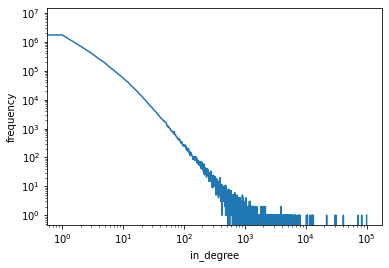

In [38]:
counts = Counter(d for n, d in G.in_degree())
in_degree_freq = [counts.get(i, 0) for i in range(max(counts) + 1)]

plt.loglog(range(len(in_degree_freq)), in_degree_freq)
plt.xlabel('in_degree')
plt.ylabel('frequency')
plt.show()

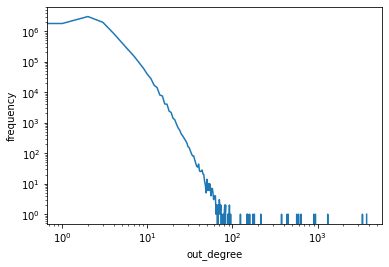

In [39]:
counts = Counter(d for n, d in G.out_degree())
out_degree_freq = [counts.get(i, 0) for i in range(max(counts) + 1)]

plt.loglog(range(len(out_degree_freq)), out_degree_freq)
plt.xlabel('out_degree')
plt.ylabel('frequency')
plt.show()

In [40]:
# [(n, depth[n]) for n in G.successors('Chairs')]

In [41]:
# descendants_by_depth = [(len(nx.descendants(G, node)), depth[node]) for node in depth.keys()]